In [1]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# basic libraries
import pandas as pd
import numpy as np
# plot-kits
import seaborn as sns
from matplotlib import pyplot as plt

In [8]:
# load dataset
df = pd.read_csv("Credit Card Default II.csv", encoding='utf-8')
print(df)

      clientid       income        age         loan  default
0            1  66155.92510  59.017015  8106.532131        0
1            2  34415.15397  48.117153  6564.745018        0
2            3  57317.17006  63.108049  8020.953296        0
3            4  42709.53420  45.751972  6103.642260        0
4            5  66952.68885  18.584336  8770.099235        1
...        ...          ...        ...          ...      ...
1995      1996  59221.04487  48.518179  1926.729397        0
1996      1997  69516.12757  23.162104  3503.176156        0
1997      1998  44311.44926  28.017167  5522.786693        1
1998      1999  43756.05660  63.971796  1622.722598        0
1999      2000  69436.57955  56.152617  7378.833599        0

[2000 rows x 5 columns]


In [9]:
# data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

## basic data cleaning
df.info()
df = df.drop('clientid', axis=1)
df['age'] = abs(df['age'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   clientid  2000 non-null   int64  
 1   income    2000 non-null   float64
 2   age       1997 non-null   float64
 3   loan      2000 non-null   float64
 4   default   2000 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 78.2 KB


<AxesSubplot:xlabel='loan'>

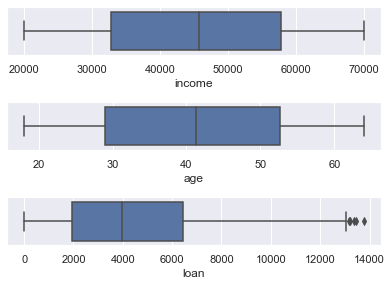

In [10]:
## boxplot for outlier judgement
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3,1)
fig.tight_layout(h_pad=2)

plt.subplot(3,1,1)
sns.boxplot(data=df, x='income')

plt.subplot(3,1,2)
sns.boxplot(data=df, x='age')

plt.subplot(3,1,3)
sns.boxplot(data=df, x='loan')

In [11]:
## missing value substitution
df['age']=SimpleImputer(missing_values=np.nan, 
                        strategy='mean').fit_transform(df[['age']])

In [12]:
## drop outliers
from scipy import stats
zscore = np.abs(stats.zscore(df[['loan']]))
df = df[(zscore<2.5).all(axis=1)]

Text(255.32941176470592, 0.5, '')

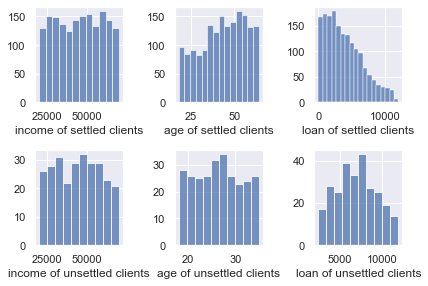

In [13]:
## categorize clients
settled = df.loc[df['default']==0, :]
unsettled = df.loc[df['default']==1, :]

## client-characteristic sketch
fig, ax=plt.subplots(2,3)
fig.tight_layout(h_pad=2)
plt.subplot(2, 3, 1)
sns.histplot(data=settled,
            x='income')
plt.xlabel('income of settled clients')
plt.ylabel(None)
plt.subplot(2, 3, 2)
sns.histplot(data=settled,
            x='age')
plt.xlabel('age of settled clients')
plt.ylabel(None)
plt.subplot(2, 3, 3)
sns.histplot(data=settled,
            x='loan')
plt.xlabel('loan of settled clients')
plt.ylabel(None)
plt.subplot(2, 3, 4)
sns.histplot(data=unsettled,
            x='income')
plt.xlabel('income of unsettled clients')
plt.ylabel(None)
plt.subplot(2, 3, 5)
sns.histplot(data=unsettled,
            x='age')
plt.xlabel('age of unsettled clients')
plt.ylabel(None)
plt.subplot(2, 3, 6)
sns.histplot(data=unsettled,
            x='loan')
plt.xlabel('loan of unsettled clients')
plt.ylabel(None)

In [14]:
## normalization
df['income'] = StandardScaler().fit_transform(df[['income']])
df['age'] = StandardScaler().fit_transform(df[['age']])
df['loan'] = StandardScaler().fit_transform(df[['loan']])

    level_0  level_1  correlation
0    income   income     1.000000
1    income      age    -0.032987
2    income     loan     0.413223
3    income  default    -0.017228
4       age   income    -0.032987
5       age      age     1.000000
6       age     loan     0.011081
7       age  default    -0.437854
8      loan   income     0.413223
9      loan      age     0.011081
10     loan     loan     1.000000
11     loan  default     0.367506
12  default   income    -0.017228
13  default      age    -0.437854
14  default     loan     0.367506
15  default  default     1.000000


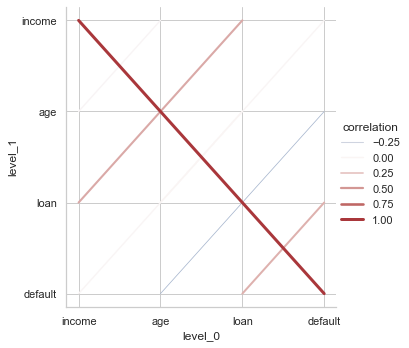

In [15]:
## relation-plot
corr_mat = df.corr().stack().reset_index(name="correlation")
print(corr_mat)
sns.set_theme(style="whitegrid")
fig = sns.relplot(data=corr_mat, 
            x='level_0', 
            y='level_1', 
            hue='correlation', 
            size='correlation',
            palette="vlag", 
            hue_norm=(-1, 1),
            kind='line'
            )

In [16]:
# train-test split
from sklearn.model_selection import train_test_split
X = df.drop('default', axis=1)
Y = df['default']
x_train, x_test, y_train, y_test=train_test_split(X, Y, 
                                                  test_size=.33,
                                                  random_state=42)

In [23]:
# parameter tuning
from sklearn.metrics import confusion_matrix, roc_auc_score

# model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


Best parameter match:
max_iter          11.000000
Accuracy           0.941718
F1_Score           0.966071
AUC_Score          0.980217
Weighted_Score     0.965838
Name: 1, dtype: float64


<AxesSubplot:xlabel='max_iter', ylabel='Weighted_Score'>

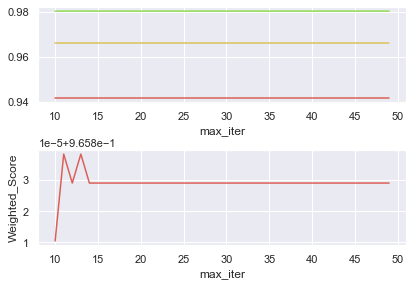

In [26]:
## Logistic Regression
iter_ls = []
acc_ls = []
f1_ls = []
roc_ls = []
model_score = []
for i in range(10, 50, 1):
    LR_TEST = LogisticRegression(max_iter=i, 
                                 solver='lbfgs', 
                                 multi_class='multinomial',
                                 ).fit(x_train, y_train)
    pred = LR_TEST.predict(x_test)
    predprob = LR_TEST.predict_proba(x_test)[:, 1]

    # metrics
    cm = confusion_matrix(y_test, pred)
    acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
    prc = cm[0,0]/(cm[0,0]+cm[1,0])
    rc = cm[0,0]/(cm[0,0]+cm[0,1])
    f1_score = 2*(prc*rc)/(prc+rc)
    roc = roc_auc_score(y_test, predprob)
    score = acc*0.3+f1_score*0.2+roc*0.5
    
    # store
    iter_ls.append(i)
    acc_ls.append(acc)
    f1_ls.append(f1_score)
    roc_ls.append(roc)
    model_score.append(score)
    
test_data = {'max_iter':iter_ls, 'Accuracy':acc_ls, 'F1_Score':f1_ls, 'AUC_Score':roc_ls, 'Weighted_Score':model_score}
test_df = pd.DataFrame(test_data)
print("Best parameter match:")
print(test_df.loc[model_score.index(max(model_score)), :])

# model performance curve
sns.set_theme(style='darkgrid')
sns.set_palette(sns.color_palette('hls', 8))
fig, ax=plt.subplots(2,1)
fig.tight_layout(h_pad=2)
plt.subplot(2,1,1)
sns.lineplot(x='max_iter',
             y='Accuracy',
             data=test_df,)
sns.lineplot(x='max_iter',
             y='F1_Score',
             data=test_df,)
sns.lineplot(x='max_iter',
             y='AUC_Score',
             data=test_df,)
plt.ylabel(None)
plt.subplot(2,1,2)
sns.lineplot(x='max_iter',
             y='Weighted_Score',
             data=test_df)

Best parameter match:
max_depth         7.000000
Accuracy          0.981595
F1_Score          0.989111
AUC_Score         0.982381
Weighted_Score    0.983491
Name: 4, dtype: float64


<AxesSubplot:xlabel='max_depth', ylabel='Weighted_Score'>

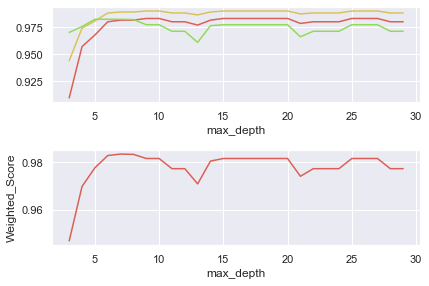

In [27]:
## CART Decision Tree
depth_ls = []
acc_ls = []
f1_ls = []
roc_ls = []
model_score = []
for i in range(3,30,1):
    DT_TEST = DecisionTreeClassifier(criterion='gini',
                                     max_depth=i,
                                     class_weight='balanced',
                                     ).fit(x_train, y_train)
    pred = DT_TEST.predict(x_test)
    predprob = DT_TEST.predict_proba(x_test)[:, 1]
    
    # metrics
    cm = confusion_matrix(y_test, pred)
    acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
    prc = cm[0,0]/(cm[0,0]+cm[1,0])
    rc = cm[0,0]/(cm[0,0]+cm[0,1])
    f1_score = 2*(prc*rc)/(prc+rc)
    roc = roc_auc_score(y_test, predprob)
    score = acc*0.3+f1_score*0.2+roc*0.5
    
    # store
    depth_ls.append(i)
    acc_ls.append(acc)
    f1_ls.append(f1_score)
    roc_ls.append(roc)
    model_score.append(score)
   
test_data = {'max_depth':depth_ls, 'Accuracy':acc_ls, 'F1_Score':f1_ls, 'AUC_Score':roc_ls, 'Weighted_Score':model_score}
test_df = pd.DataFrame(test_data)
print("Best parameter match:")
print(test_df.loc[model_score.index(max(model_score)), :])

# model performance curve
fig, ax=plt.subplots(2,1)
fig.tight_layout(h_pad=2)
plt.subplot(2,1,1)
sns.lineplot(x='max_depth',
             y='Accuracy',
             data=test_df,)
sns.lineplot(x='max_depth',
             y='F1_Score',
             data=test_df,)
sns.lineplot(x='max_depth',
             y='AUC_Score',
             data=test_df,)
plt.ylabel(None)
plt.subplot(2,1,2)
sns.lineplot(x='max_depth',
             y='Weighted_Score',
             data=test_df)

Best parameter match:
estimator         91.000000
Accuracy           0.989264
F1_Score           0.993699
AUC_Score          0.999313
Weighted_Score     0.995175
Name: 90, dtype: float64


<AxesSubplot:xlabel='estimator', ylabel='Weighted_Score'>

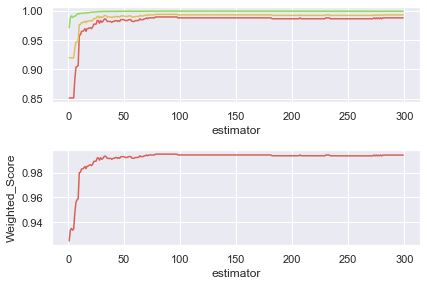

In [28]:
## Gradient Boosting Decision Tree
estimator_ls = []
acc_ls = []
f1_ls = []
roc_ls = []
model_score = []

for i in range(1,300,1):
    GBDT_TEST = GradientBoostingClassifier(n_estimators=i,
                                           loss='deviance',
                                           ).fit(x_train, y_train)
    pred = GBDT_TEST.predict(x_test)
    predprob = GBDT_TEST.predict_proba(x_test)[:, 1]
    
    # metrics
    cm = confusion_matrix(y_test, pred)
    acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
    prc = cm[0,0]/(cm[0,0]+cm[1,0])
    rc = cm[0,0]/(cm[0,0]+cm[0,1])
    f1_score = 2*(prc*rc)/(prc+rc)
    roc = roc_auc_score(y_test, predprob)
    score = acc*0.3+f1_score*0.2+roc*0.5
    
    # store
    estimator_ls.append(i)
    acc_ls.append(acc)
    f1_ls.append(f1_score)
    roc_ls.append(roc)
    model_score.append(score)

test_data = {'estimator':estimator_ls, 'Accuracy':acc_ls, 'F1_Score':f1_ls, 'AUC_Score':roc_ls, 'Weighted_Score':model_score}
test_df = pd.DataFrame(test_data)
print("Best parameter match:")
print(test_df.loc[model_score.index(max(model_score)), :])

# model performance curve
fig, ax=plt.subplots(2,1)
fig.tight_layout(h_pad=2)
plt.subplot(2,1,1)
sns.lineplot(x='estimator',
             y='Accuracy',
             data=test_df,)
sns.lineplot(x='estimator',
             y='F1_Score',
             data=test_df,)
sns.lineplot(x='estimator',
             y='AUC_Score',
             data=test_df,)
plt.ylabel(None)
plt.subplot(2,1,2)
sns.lineplot(x='estimator',
             y='Weighted_Score',
             data=test_df)

Best parameter match:
estimator         125.000000
Accuracy            0.989264
F1_Score            0.993722
AUC_Score           0.999313
Weighted_Score      0.995180
Name: 124, dtype: float64


<AxesSubplot:xlabel='estimator', ylabel='Weighted_Score'>

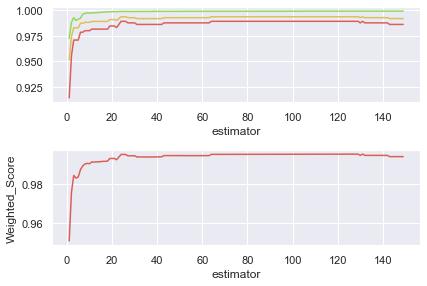

In [29]:
## XGBoost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# parameter tuning
estimator_ls = []
acc_ls = []
f1_ls = []
roc_ls = []
model_score = []

for i in range(1,150,1):
    XGB_TEST = XGBClassifier(n_estimators=i,
                                max_depth=3,
                                eval_metric=['logloss','auc','error'],
                                ).fit(x_train, y_train)
    pred = XGB_TEST.predict(x_test)
    predprob = XGB_TEST.predict_proba(x_test)[:, 1]
    
    # metrics
    cm = confusion_matrix(y_test, pred)
    acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
    prc = cm[0,0]/(cm[0,0]+cm[1,0])
    rc = cm[0,0]/(cm[0,0]+cm[0,1])
    f1_score = 2*(prc*rc)/(prc+rc)
    roc = roc_auc_score(y_test, predprob)
    score = acc*0.3+f1_score*0.2+roc*0.5
    
    # store
    estimator_ls.append(i)
    acc_ls.append(acc)
    f1_ls.append(f1_score)
    roc_ls.append(roc)
    model_score.append(score)
    
test_data = {'estimator':estimator_ls, 'Accuracy':acc_ls, 'F1_Score':f1_ls, 'AUC_Score':roc_ls, 'Weighted_Score':model_score}
test_df = pd.DataFrame(test_data)
print("Best parameter match:")
print(test_df.loc[model_score.index(max(model_score)), :])

# model performance curve
fig, ax=plt.subplots(2,1)
fig.tight_layout(h_pad=2)
plt.subplot(2,1,1)
sns.lineplot(x='estimator',
             y='Accuracy',
             data=test_df,)
sns.lineplot(x='estimator',
             y='F1_Score',
             data=test_df,)
sns.lineplot(x='estimator',
             y='AUC_Score',
             data=test_df,)
plt.ylabel(None)
plt.subplot(2,1,2)
sns.lineplot(x='estimator',
             y='Weighted_Score',
             data=test_df)

In [30]:
# Logistic Regression Model
LR = LogisticRegression(max_iter=11, 
                        solver='lbfgs', 
                        multi_class='multinomial',
                        ).fit(x_train, y_train)
pred = LR.predict(x_test)
predprob = LR.predict_proba(x_test)[:, 1]

# metrics
cm = confusion_matrix(y_test, pred)
print(cm)
acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
prc = cm[0,0]/(cm[0,0]+cm[1,0])
rc = cm[0,0]/(cm[0,0]+cm[0,1])
f1_score = 2*(prc*rc)/(prc+rc)
roc = roc_auc_score(y_test, predprob)
score = acc*0.3+f1_score*0.2+roc*0.5

# training results
print("Accuracy of Logistic Regression:", '%.2f'%(100*acc), "%")
print("F1-Score of Logistic Regression:", '%.2f'%(100*f1_score), "%")
print("ROC of Logistic Regression:", '%.2f'%(100*roc), "%")
print("Evaluation Score:", '%.2f'%(100*score), "%")

[[541  14]
 [ 24  73]]
Accuracy of Logistic Regression: 94.17 %
F1-Score of Logistic Regression: 96.61 %
ROC of Logistic Regression: 98.02 %
Evaluation Score: 96.58 %


In [31]:
# Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB().fit(x_train, y_train)
pred = GNB.predict(x_test)
predprob = GNB.predict_proba(x_test)[:, 1]
    
# metrics
cm = confusion_matrix(y_test, pred)
print(cm)
acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
prc = cm[0,0]/(cm[0,0]+cm[1,0])
rc = cm[0,0]/(cm[0,0]+cm[0,1])
f1_score = 2*(prc*rc)/(prc+rc)
roc = roc_auc_score(y_test, predprob)
score = acc*0.3+f1_score*0.2+roc*0.5

# training results
print("Accuracy of Gaussian Naive Bayes Classifier:", '%.2f'%(100*acc), "%")
print("F1-Score of Gaussian Naive Bayes Classifier:", '%.2f'%(100*f1_score), "%")
print("ROC of Gaussian Naive Bayes Classifier:", '%.2f'%(100*roc), "%")
print("Evaluation Score:", '%.2f'%(100*score), "%")

[[544  11]
 [ 34  63]]
Accuracy of Gaussian Naive Bayes Classifier: 93.10 %
F1-Score of Gaussian Naive Bayes Classifier: 96.03 %
ROC of Gaussian Naive Bayes Classifier: 97.12 %
Evaluation Score: 95.69 %


In [32]:
# Decision Tree Model
DT = DecisionTreeClassifier(criterion='gini',
                                 max_depth=7,
                                 class_weight='balanced',
                                 ).fit(x_train, y_train)
pred = DT.predict(x_test)
predprob = DT.predict_proba(x_test)[:, 1]

# metrics
cm = confusion_matrix(y_test, pred)
print(cm)
acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
prc = cm[0,0]/(cm[0,0]+cm[1,0])
rc = cm[0,0]/(cm[0,0]+cm[0,1])
f1_score = 2*(prc*rc)/(prc+rc)
roc = roc_auc_score(y_test, predprob)
score = acc*0.2+f1_score*0.3+roc*0.5

# training results
print("Accuracy of Decision Tree Classifier:", '%.2f'%(100*acc), "%")
print("F1-Score of Decision Tree Classifier:", '%.2f'%(100*f1_score), "%")
print("ROC of Decision Tree Classifier:", '%.2f'%(100*roc), "%")
print("Evaluation Score:", '%.2f'%(100*score), "%")

[[545  10]
 [  2  95]]
Accuracy of Decision Tree Classifier: 98.16 %
F1-Score of Decision Tree Classifier: 98.91 %
ROC of Decision Tree Classifier: 98.24 %
Evaluation Score: 98.42 %


In [33]:
# Gradient Boosting Model
GBDT = GradientBoostingClassifier(n_estimators=91,
                                  loss='deviance',
                                  ).fit(x_train, y_train)
pred = GBDT.predict(x_test)
predprob = GBDT.predict_proba(x_test)[:, 1]

# metrics
cm = confusion_matrix(y_test, pred)
print(cm)
acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
prc = cm[0,0]/(cm[0,0]+cm[1,0])
rc = cm[0,0]/(cm[0,0]+cm[0,1])
f1_score = 2*(prc*rc)/(prc+rc)
roc = roc_auc_score(y_test, predprob)
score = acc*0.3+f1_score*0.2+roc*0.5

# training results
print("Accuracy of Gradient Boosting Decision Tree Classifier:", '%.2f'%(100*acc), "%")
print("F1-Score of Gradient Boosting Decision Tree Classifier:", '%.2f'%(100*f1_score), "%")
print("ROC of Decision Tree Classifier:", '%.2f'%(100*roc), "%")
print("Evaluation Score:", '%.2f'%(100*score), "%")

[[552   3]
 [  4  93]]
Accuracy of Gradient Boosting Decision Tree Classifier: 98.93 %
F1-Score of Gradient Boosting Decision Tree Classifier: 99.37 %
ROC of Decision Tree Classifier: 99.93 %
Evaluation Score: 99.52 %


In [34]:
# eXtreme Gradient Boosting Model (Recommended)
XGB = XGBClassifier(n_estimators=125,
                         max_depth=3,
                         eval_metric=['logloss','auc','error'],
                         ).fit(x_train, y_train)
pred = XGB.predict(x_test)
predprob = XGB.predict_proba(x_test)[:, 1]

# metrics
cm = confusion_matrix(y_test, pred)
print(cm)
acc = (cm[0,0]+cm[1,1])/(sum(sum(cm)))
prc = cm[0,0]/(cm[0,0]+cm[1,0])
rc = cm[0,0]/(cm[0,0]+cm[0,1])
f1_score = 2*(prc*rc)/(prc+rc)
roc = roc_auc_score(y_test, predprob)
score = acc*0.3+f1_score*0.2+roc*0.5

# training results
print("Accuracy of eXtreme Gradient Boosting Decision Tree Classifier:", '%.2f'%(100*acc), "%")
print("F1-Score of eXtreme Gradient Boosting Decision Tree Classifier:", '%.2f'%(100*f1_score), "%")
print("ROC of eXtreme Decision Tree Classifier:", '%.2f'%(100*roc), "%")
print("Evaluation Score:", '%.2f'%(100*score), "%")

[[554   1]
 [  6  91]]
Accuracy of eXtreme Gradient Boosting Decision Tree Classifier: 98.93 %
F1-Score of eXtreme Gradient Boosting Decision Tree Classifier: 99.37 %
ROC of eXtreme Decision Tree Classifier: 99.93 %
Evaluation Score: 99.52 %
